# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
env = UnityEnvironment(file_name='../../Reacher_v1.app')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Training a ddpg agent

In [4]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from model import Actor, Critic
from ddpg_agent import Agent

# for MAC os
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
use_cuda

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

In [6]:
def ddpg(n_episodes=1000, max_t=10000):
    """DDQN Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    
    scores = []
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]            
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)          
       
            env_info = env.step(action)[brain_name]        
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                  
            done = env_info.local_done[0]                  
            agent.step(state, action, reward, next_state, done) 
            score += reward                                
            state = next_state                             
            if done:                                      
                break
        
        scores_deque.append(score)       
        scores.append(score)             
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} Episodes \tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_v1_cpu.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_v1_cpu.pth')
            break
            
    return scores

In [7]:
scores = ddpg(n_episodes = 500)

Episode 1	Average Score: 0.64
Episode 2	Average Score: 1.06
Episode 3	Average Score: 0.74
Episode 4	Average Score: 0.68
Episode 5	Average Score: 0.61
Episode 6	Average Score: 0.66
Episode 7	Average Score: 0.63
Episode 8	Average Score: 0.63
Episode 9	Average Score: 0.63
Episode 10	Average Score: 0.62
Episode 11	Average Score: 0.61
Episode 12	Average Score: 0.61
Episode 13	Average Score: 0.63
Episode 14	Average Score: 0.62
Episode 15	Average Score: 0.75
Episode 16	Average Score: 0.77
Episode 17	Average Score: 0.83
Episode 18	Average Score: 0.89
Episode 19	Average Score: 0.98
Episode 20	Average Score: 0.99
Episode 21	Average Score: 0.98
Episode 22	Average Score: 1.07
Episode 23	Average Score: 1.06
Episode 24	Average Score: 1.12
Episode 25	Average Score: 1.12
Episode 26	Average Score: 1.25
Episode 27	Average Score: 1.23
Episode 28	Average Score: 1.30
Episode 29	Average Score: 1.34
Episode 30	Average Score: 1.40
Episode 31	Average Score: 1.40
Episode 32	Average Score: 1.39
Episode 33	Averag

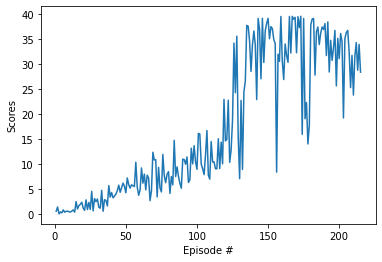

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()

### Testing ddpg agent 

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_v1_cpu.pth'))

<All keys matched successfully>

In [12]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
agent.reset()

while True:

    actions = agent.act(states)                        # get actions from actor
    
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 39.409999119117856


In [13]:
env.close()